<a href="https://colab.research.google.com/github/asubedi2001/FakeNewsDetection/blob/BiLSTM/BiLSTMwithHyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Dataset columns(14 in total) peek:
  id
  label
  claim
  subject
  speaker
  speaker_job_title
  state_info
  party_affiliation
  barely_true_counts
  false_counts
  half_true_counts
  mostly_true_counts
  pants_on_fire_counts
  context
The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   claim                 10240 non-null  object 
 3   subject               10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   speaker_job_title     7342 non-null   object 
 6   state_info            8030 non-null   object 
 7   party_affiliation     10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_coun

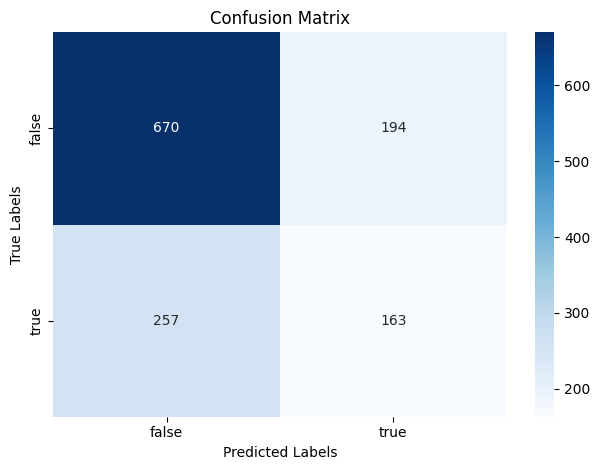

The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1267 non-null   object
 1   label                 1267 non-null   object
 2   claim                 1267 non-null   object
 3   subject               1267 non-null   object
 4   speaker               1267 non-null   object
 5   speaker_job_title     942 non-null    object
 6   state_info            1005 non-null   object
 7   party_affiliation     1267 non-null   object
 8   barely_true_counts    1267 non-null   int64 
 9   false_counts          1267 non-null   int64 
 10  half_true_counts      1267 non-null   int64 
 11  mostly_true_counts    1267 non-null   int64 
 12  pants_on_fire_counts  1267 non-null   int64 
 13  context               1250 non-null   object
dtypes: int64(5), object(9)
memory usage: 138.7+ KB

Data peek:
       

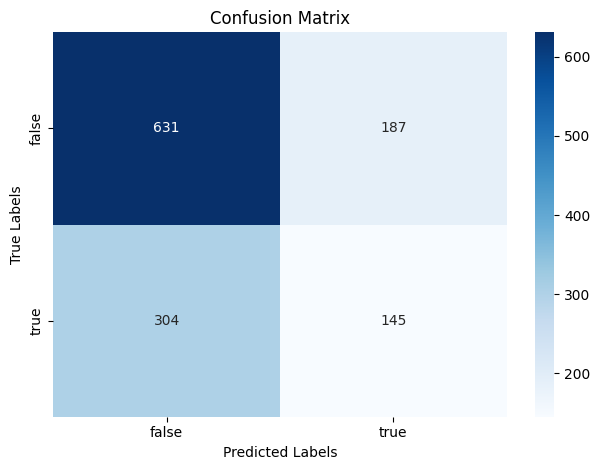

In [1]:
# -*- coding: utf-8 -*-
"""GRUwithRelabling(11).ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1vBZZ-V5_C9Cu1wS4yWpAGUceU8s033H1
"""

import numpy as np
import pandas as pd
import random
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import pprint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
random.seed(184)

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

"""## Read in data"""

peek = 20
def present_list_like(name, list_like, peek=peek):
    print(f"{name} peek:")
    print('  ' + '\n  '.join( str(v) for v in list_like[:peek]))

columns = [
    'id', 'label', 'claim', 'subject', 'speaker', 'speaker_job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]
present_list_like(f"Dataset columns({len(columns)} in total)", columns, len(columns))
def load_data(split):
    df = pd.read_csv(f"./data/{split}.tsv", sep='\t', names=columns)
    df = df.drop(index=[
        idx for idx in df.index if type(df["claim"][idx]) == type(None) or not len(df["claim"][idx])
    ])
    print("The training dataset:")
    df.info()
    print("\nData peek:")
    print(df.head(peek))
    print()
    return df

"""##Tokenize the data"""

pad_tkn = "<PAD>"

def tokenize_text(input_text, known_vector_size=None, token_to_idx={}):
    def preprocess_text(text)->str:
        #Letter-level cleaning
        text = text.lower()
        valid_asciis = {9, *range(32, 127)}
        text = ''.join(filter(lambda x: ord(x) in valid_asciis, text))

        #Word/sequence-level cleaning
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'http\S+', '', text)
        stop_words = set(stopwords.words('english'))
        text = ' '.join(word for word in text.split() if word not in stop_words)
        return text

    #Preprocess the text
    for i in range(len(input_text)):
        input_text[i] = preprocess_text(input_text[i])

    #Tokenize
    final_tokens = input_tokens = [nltk.word_tokenize(text) for text in input_text]
    total_tokens = sum(len(tkns) for tkns in final_tokens)

    # Make all token sets the same length
    forced_tkn_set_size = (
        known_vector_size if known_vector_size
        else int(np.percentile([len(tkns) for tkns in final_tokens], 80))
    )
    final_tokens = [
        tkns[:forced_tkn_set_size] + [pad_tkn]*(forced_tkn_set_size - len(tkns))
        for tkns in final_tokens
    ]

    # Present results
    present_list_like(f"Tokenized sentences({len(final_tokens)} sentences, {total_tokens} total tokens)", final_tokens)

    #Index the tokens
    # Map each token to its frequency in the dataset
    if not len(token_to_idx):
        flat_tokens = [word for token_set in final_tokens for word in token_set]
        frequencies = Counter(flat_tokens)
        token_to_idx = {}
        for idx, (word, _) in enumerate(frequencies.most_common()):
            if idx >= 10000:
                break
            token_to_idx[word] = idx + 1
        if pad_tkn not in token_to_idx:
            token_to_idx[pad_tkn] = len(token_to_idx) + 1
    vocab_size = len(token_to_idx)
    print()
    print(vocab_size, "unique tokens")
    present_list_like("Unique tokens", list(token_to_idx.keys()))

    # Index the tokens
    freq_indexed = [
        [(token_to_idx[token] if token in token_to_idx else 0) for token in token_set]
        for token_set in final_tokens
    ]

    # Present results
    present_list_like(f"\nFinal Index Sets(Set_Size = {forced_tkn_set_size}, {len(freq_indexed)} index sets)", freq_indexed)

    return freq_indexed, token_to_idx

def get_freq_indexed_and_labels(split, known_vector_size=None, token_to_idx={}):
    df = load_data(split)
    input_text = df["claim"].to_numpy()
    #Augment input text with the other columns
    other_cols = {
        "context",
        "subject",
        "speaker",
        "speaker_job_title",
        "state_info",
        "party_affiliation",
    }
    for i in range(len(input_text)):
        extra_data = [f"{col}: {df[col].values[i]}" for col in other_cols if df[col].values[i]]
        input_text[i] += " | \n"*(len(extra_data) > 0) + " | \n".join(extra_data)
    input_labels = df["label"].to_numpy()
    code_switch = """"""
    #Fuse some labels
    input_labels = np.array([
        "false" if x in ("false", "half-true", "barely-true", "pants-fire")
        else "true" if x in ("true", "mostly-true")
        else x
        for x in input_labels
    ])
    #"""
    freq_indexed, token_to_idx = tokenize_text(input_text, known_vector_size, token_to_idx)

    return freq_indexed, token_to_idx, input_labels

"""##Turn the data into tensors"""

def as_tensors(split, label_encoder=None, known_vector_size=None, token_to_idx={}):
    freq_indexed, token_to_idx, input_labels = get_freq_indexed_and_labels(split, known_vector_size, token_to_idx)
    X = torch.tensor(freq_indexed, dtype=torch.long)
    label_encoder_existed = (type(label_encoder) != type(None))
    label_encoder = (LabelEncoder() if not label_encoder_existed else label_encoder)
    y = (
        label_encoder.fit_transform(input_labels) if not label_encoder_existed
        else label_encoder.transform(input_labels)
    )
    y = torch.tensor(y, dtype=torch.long)
    print(f"{split.upper()} SPLIT:", X.size(0), "overall samples:", X.shape)

    return X, token_to_idx, label_encoder, input_labels, y

"""##Training"""

BATCH_SIZE = 32

X_train, token_to_idx, label_encoder, train_input_labels, y_train = as_tensors("train")
label_to_idx = {l: i for i, l in enumerate(label_encoder.classes_)}
train_vocab_size = len(token_to_idx)
input_vector_size = X_train.shape[1]
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_label_counts = pd.DataFrame({"label": train_input_labels})["label"].value_counts(normalize=True)
print(train_label_counts.shape[0], "labels\n")
print(train_label_counts)

code_switch = "\"""""
#Balance if necessary
print(f"TRAIN SPLIT(pre-balancing):", X_train.size(0), "overall samples:", X_train.shape)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
print()
print(f"TRAIN SPLIT(post-balancing):", X_train.size(0), "overall samples:", X_train.shape)
print(pd.DataFrame({"label": [label_encoder.classes_[y] for y in y_train]})["label"].value_counts())
#"""

def train_model(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_tps = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() #Track total loss
            #Track total accuracy
            _, predicted_classes = torch.max(predictions, 1)
            epoch_tps += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f} | Accuracy: {epoch_tps/total_samples:.4f}")

"""### The BiLSTM model"""

#Define the model

import torch
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=token_to_idx[pad_tkn])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

#Setup to train

# Model and training structure
INPUT_DIM = train_vocab_size + 1
EMBEDDING_DIM = 1000 #Current best: 1000
HIDDEN_DIM = 128
OUTPUT_DIM = train_label_counts.shape[0]
N_LAYERS = 2
DROPOUT = 0.3 #Current best: .3
EPOCHS = 8 #Current best: 8

# Make the model
bilstm_model = BiLSTMModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
print("Model:", bilstm_model)

# Move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    # Verify if a T4 GPU is available
    t4_available = any("t4" in torch.cuda.get_device_name(i).lower() for i in range(num_gpus))
    print(f"Is a T4 GPU available? {t4_available}")

    # Set the device to the first available GPU (if any)
    device = torch.device('cuda:0')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU.")
    device = torch.device('cpu')
bilstm_model = bilstm_model.to(device)

# Optimization & loss setup
optimizer = torch.optim.AdamW(bilstm_model.parameters(), lr=0.001)
code_switch1 = """"""
class_weights = [1 for _ in range(OUTPUT_DIM)]
class_weights[label_to_idx['true']] = 1
class_weights[label_to_idx['false']] = 2
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
code_switch2 = """
criterion = nn.CrossEntropyLoss() #Current best: no weights
#"""
criterion = criterion.to(device)

#Train the model
train_model(bilstm_model, train_loader, optimizer, criterion, device, EPOCHS)

"""## Save Model Weights"""

#Save the model weights
torch.save(bilstm_model.state_dict(), "bilstm_model_weights.pth")
print("Model weights saved to 'bilstm_model_weights.pth'")

"""## Evaluate Model"""

#Evaluation functions
import typing as tp

# Get predictions
def get_predictions(
    test_loader, model, num_samples,
    pred_type: tp.Literal['model', 'baseline', 'random'] = 'model',
    device=None,
    label_ordering=None, orig_label_counts=None,
    num_classes=None
):
    predictions = []
    y_eval = []

    if pred_type == 'model':
        model.eval()
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                y_eval.extend(batch_y)

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                batch_size = batch_X.size(0)

                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu())
        y_eval = torch.tensor(y_eval, dtype=torch.long)
    elif pred_type == 'baseline':
        orig_label_counts = orig_label_counts.sort_index(key=lambda idx: orig_label_counts[idx], inplace=False, ascending=False)
        majority_class = list(label_ordering).index(orig_label_counts.index[0])
        predictions += [majority_class for _ in range(num_samples)]
    else:
        predictions += [random.randint(0, num_classes - 1) for _ in range(num_samples)]

    predictions = torch.tensor(predictions, dtype=torch.long)
    if pred_type == 'model':
        return predictions, y_eval
    return predictions

# Calculate per-class metrics
def per_class_metrics(labels, predictions, num_classes, label_ordering):
    # Ensure labels and predictions are on CPU
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_per_class = precision_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)
    recall_per_class = recall_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)
    f1_per_class = f1_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)

    results = []
    for metrics in [precision_per_class, recall_per_class, f1_per_class]:
        results.append({label_ordering[i]: metrics[i] for i in range(len(metrics))})
    return tuple(results)

# Calculate Macro metrics
def macro_metrics(labels, predictions):
    # Ensure labels and predictions are on CPU
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)

    return precision_macro, recall_macro, f1_macro

# Calculate Micro metrics
def micro_metrics(labels, predictions):
    # Ensure labels and predictions are on CPU
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_micro = precision_score(labels, predictions, average='micro', zero_division=0)
    recall_micro = recall_score(labels, predictions, average='micro', zero_division=0)
    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)

    return precision_micro, recall_micro, f1_micro

# Get evaluations
def evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering):
    results = {}

    for pred_type, predictions in [('Model', model_pred), ('Baseline', baseline_pred), ('Random', random_pred)]:
        curr_results = results[pred_type] = {}

        # Calculate metrics
        accuracy = (predictions == labels).sum().item() / labels.size(0)
        precision_per_class, recall_per_class, f1_per_class = per_class_metrics(labels, predictions, num_classes, label_ordering)
        precision_macro, recall_macro, f1_macro = macro_metrics(labels, predictions)
        precision_micro, recall_micro, f1_micro = micro_metrics(labels, predictions)

        # Save all metrics
        curr_results["Accuracy"] = accuracy
        curr_results["Per-Class Precision"] = precision_per_class
        curr_results["Per-Class Recall"] = recall_per_class
        curr_results["Per-Class F1"] = f1_per_class

        curr_results["Macro Precision"] = precision_macro
        curr_results["Macro Recall"] = recall_macro
        curr_results["Macro F1"] = f1_macro

        curr_results["Micro Precision"] = precision_micro
        curr_results["Micro Recall"] = recall_micro
        curr_results["Micro F1"] = f1_micro

    return results

def evaluate_data(model, loader, num_classes, num_instances, label_ordering, orig_label_counts, device):
    # Get model, baseline, and random predictions
    # Use model predictions to get the labels since the
    # loader might shuffle its values and might not be in the same order as y upon iteration
    model_pred, labels = get_predictions(loader, model, num_instances, pred_type='model', device=device)
    # Get other prediction types as normal
    baseline_pred = get_predictions(
        loader, model, num_instances, pred_type='baseline',
        label_ordering=label_ordering, orig_label_counts=orig_label_counts
    )
    random_pred = get_predictions(loader, model, num_instances, pred_type='random', num_classes=num_classes)

    print()

    # Move tensors to CPU before passing to sklearn functions
    labels = labels.cpu()
    model_pred = model_pred.cpu()
    baseline_pred = baseline_pred.cpu()
    random_pred = random_pred.cpu()

    # Print evaluation results
    pprint.pprint(evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering))

    # Generate confusion matrix and move to CPU
    conf_matrix = confusion_matrix(labels.cpu(), model_pred.cpu())
    class_labels = label_ordering

    # Plot the confusion matrix as a heatmap
    def plot_confusion_matrix(conf_matrix, class_labels):
        sns.heatmap(
            conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.tight_layout()
        plt.show()

    print("\n")
    plot_confusion_matrix(conf_matrix, class_labels)

"""###Val Set Results"""

X_val, _, _, _, y_val = as_tensors("valid", label_encoder, input_vector_size, token_to_idx)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

evaluate_data(bilstm_model, val_loader, OUTPUT_DIM, y_val.size(0), label_encoder.classes_, train_label_counts, device)

"""###Test Set Results"""

X_test, _, _, _, y_test = as_tensors("test", label_encoder, input_vector_size, token_to_idx)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

evaluate_data(bilstm_model, test_loader, OUTPUT_DIM, y_test.size(0), label_encoder.classes_, train_label_counts, device)

In [3]:
import numpy as np
import pandas as pd
import random
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
import pprint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hyperopt imports
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

random.seed(184)

nltk.download('stopwords')
nltk.download('punkt')

peek = 20

def present_list_like(name, list_like, peek=peek):
    print(f"{name} peek:")
    print('  ' + '\n  '.join(str(v) for v in list_like[:peek]))

columns = [
    'id', 'label', 'claim', 'subject', 'speaker', 'speaker_job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]
present_list_like(f"Dataset columns({len(columns)} in total)", columns, len(columns))

def load_data(split):
    df = pd.read_csv(f"./data/{split}.tsv", sep='\t', names=columns)
    df = df.drop(index=[
        idx for idx in df.index if type(df["claim"][idx]) == type(None) or not len(df["claim"][idx])
    ])
    print("The training dataset:")
    df.info()
    print("\nData peek:")
    print(df.head(peek))
    print()
    return df

pad_tkn = "<PAD>"

def tokenize_text(input_text, known_vector_size=None, token_to_idx={}):
    def preprocess_text(text) -> str:
        # Letter-level cleaning
        text = text.lower()
        valid_asciis = {9, *range(32, 127)}
        text = ''.join(filter(lambda x: ord(x) in valid_asciis, text))

        # Word/sequence-level cleaning
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'http\S+', '', text)
        stop_words = set(stopwords.words('english'))
        text = ' '.join(word for word in text.split() if word not in stop_words)
        return text

    # Preprocess the text
    for i in range(len(input_text)):
        input_text[i] = preprocess_text(input_text[i])

    # Tokenize
    final_tokens = input_tokens = [nltk.word_tokenize(text) for text in input_text]
    total_tokens = sum(len(tkns) for tkns in final_tokens)

    # Make all token sets the same length
    forced_tkn_set_size = (
        known_vector_size if known_vector_size
        else int(np.percentile([len(tkns) for tkns in final_tokens], 80))
    )
    final_tokens = [
        tkns[:forced_tkn_set_size] + [pad_tkn] * (forced_tkn_set_size - len(tkns))
        for tkns in final_tokens
    ]

    # Present results
    present_list_like(
        f"Tokenized sentences({len(final_tokens)} sentences, {total_tokens} total tokens)",
        final_tokens
    )

    # Index the tokens
    # Map each token to its frequency in the dataset
    if not len(token_to_idx):
        flat_tokens = [word for token_set in final_tokens for word in token_set]
        frequencies = Counter(flat_tokens)
        token_to_idx = {}
        for idx, (word, _) in enumerate(frequencies.most_common()):
            if idx >= 10000:
                break
            token_to_idx[word] = idx + 1
        if pad_tkn not in token_to_idx:
            token_to_idx[pad_tkn] = len(token_to_idx) + 1
    vocab_size = len(token_to_idx)
    print()
    print(vocab_size, "unique tokens")
    present_list_like("Unique tokens", list(token_to_idx.keys()))

    # Index the tokens
    freq_indexed = [
        [(token_to_idx[token] if token in token_to_idx else 0) for token in token_set]
        for token_set in final_tokens
    ]

    # Present results
    present_list_like(
        f"\nFinal Index Sets(Set_Size = {forced_tkn_set_size}, {len(freq_indexed)} index sets)",
        freq_indexed
    )

    return freq_indexed, token_to_idx

def get_freq_indexed_and_labels(split, known_vector_size=None, token_to_idx={}):
    df = load_data(split)
    input_text = df["claim"].to_numpy()
    # Augment input text with the other columns
    other_cols = {
        "context",
        "subject",
        "speaker",
        "speaker_job_title",
        "state_info",
        "party_affiliation",
    }
    for i in range(len(input_text)):
        extra_data = [f"{col}: {df[col].values[i]}" for col in other_cols if df[col].values[i]]
        input_text[i] += " | \n" * (len(extra_data) > 0) + " | \n".join(extra_data)
    input_labels = df["label"].to_numpy()
    # Fuse some labels
    input_labels = np.array([
        "false" if x in ("false", "half-true", "barely-true", "pants-fire")
        else "true" if x in ("true", "mostly-true")
        else x
        for x in input_labels
    ])
    freq_indexed, token_to_idx = tokenize_text(input_text, known_vector_size, token_to_idx)

    return freq_indexed, token_to_idx, input_labels

def as_tensors(split, label_encoder=None, known_vector_size=None, token_to_idx={}):
    freq_indexed, token_to_idx, input_labels = get_freq_indexed_and_labels(split, known_vector_size, token_to_idx)
    X = torch.tensor(freq_indexed, dtype=torch.long)
    label_encoder_existed = (type(label_encoder) != type(None))
    label_encoder = (LabelEncoder() if not label_encoder_existed else label_encoder)
    y = (
        label_encoder.fit_transform(input_labels) if not label_encoder_existed
        else label_encoder.transform(input_labels)
    )
    y = torch.tensor(y, dtype=torch.long)
    print(f"{split.upper()} SPLIT:", X.size(0), "overall samples:", X.shape)

    return X, token_to_idx, label_encoder, input_labels, y

BATCH_SIZE = 32

X_train, token_to_idx, label_encoder, train_input_labels, y_train = as_tensors("train")
X_val, _, _, _, y_val = as_tensors("valid", label_encoder=label_encoder, known_vector_size=X_train.shape[1], token_to_idx=token_to_idx)

label_to_idx = {l: i for i, l in enumerate(label_encoder.classes_)}
train_vocab_size = len(token_to_idx)
input_vector_size = X_train.shape[1]

# Use validation set for evaluation during hyperparameter tuning
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_label_counts = pd.DataFrame({"label": train_input_labels})["label"].value_counts(normalize=True)
print(train_label_counts.shape[0], "labels\n")
print(train_label_counts)

# Balance if necessary
print(f"TRAIN SPLIT(pre-balancing):", X_train.size(0), "overall samples:", X_train.shape)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
print()
print(f"TRAIN SPLIT(post-balancing):", X_train.size(0), "overall samples:", X_train.shape)
print(pd.DataFrame({"label": [label_encoder.classes_[y] for y in y_train]})["label"].value_counts())

def train_model(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_tps = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Track total loss
            # Track total accuracy
            _, predicted_classes = torch.max(predictions, 1)
            epoch_tps += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

        print(
            f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f} | Accuracy: {epoch_tps/total_samples:.4f}"
        )

# Define the model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=token_to_idx[pad_tkn])
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(hidden)

# Evaluation functions (modified to return Macro F1 for optimization)
def per_class_metrics(labels, predictions, num_classes, label_ordering):
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_per_class = precision_score(
        labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0
    )
    recall_per_class = recall_score(
        labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0
    )
    f1_per_class = f1_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)

    results = []
    for metrics in [precision_per_class, recall_per_class, f1_per_class]:
        results.append({label_ordering[i]: metrics[i] for i in range(len(metrics))})
    return tuple(results)

def macro_metrics(labels, predictions):
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)

    return precision_macro, recall_macro, f1_macro

def micro_metrics(labels, predictions):
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_micro = precision_score(labels, predictions, average='micro', zero_division=0)
    recall_micro = recall_score(labels, predictions, average='micro', zero_division=0)
    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)

    return precision_micro, recall_micro, f1_micro

def evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering):
    results = {}

    for pred_type, predictions in [('Model', model_pred), ('Baseline', baseline_pred), ('Random', random_pred)]:
        curr_results = results[pred_type] = {}

        # Calculate metrics
        accuracy = (predictions == labels).sum().item() / labels.size(0)
        precision_per_class, recall_per_class, f1_per_class = per_class_metrics(
            labels, predictions, num_classes, label_ordering
        )
        precision_macro, recall_macro, f1_macro = macro_metrics(labels, predictions)
        precision_micro, recall_micro, f1_micro = micro_metrics(labels, predictions)

        # Save all metrics
        curr_results["Accuracy"] = accuracy
        curr_results["Per-Class Precision"] = precision_per_class
        curr_results["Per-Class Recall"] = recall_per_class
        curr_results["Per-Class F1"] = f1_per_class
        curr_results["Macro Precision"] = precision_macro
        curr_results["Macro Recall"] = recall_macro
        curr_results["Macro F1"] = f1_macro
        curr_results["Micro Precision"] = precision_micro
        curr_results["Micro Recall"] = recall_micro
        curr_results["Micro F1"] = f1_micro

    return results, f1_macro

# Get predictions
import typing as tp

def get_predictions(
    test_loader, model, num_samples,
    pred_type: tp.Literal['model', 'baseline', 'random'] = 'model',
    device=None,
    label_ordering=None, orig_label_counts=None,
    num_classes=None
):
    predictions = []
    y_eval = []

    if pred_type == 'model':
        model.eval()
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                y_eval.extend(batch_y)

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                batch_size = batch_X.size(0)

                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu())
        y_eval = torch.tensor(y_eval, dtype=torch.long)
    elif pred_type == 'baseline':
        orig_label_counts = orig_label_counts.sort_index(key=lambda idx: orig_label_counts[idx], inplace=False, ascending=False)
        majority_class = list(label_ordering).index(orig_label_counts.index[0])
        predictions += [majority_class for _ in range(num_samples)]
    else:
        predictions += [random.randint(0, num_classes - 1) for _ in range(num_samples)]

    predictions = torch.tensor(predictions, dtype=torch.long)
    if pred_type == 'model':
        return predictions, y_eval
    return predictions

# Hyperparameter space
space = {
    'embedding_dim': scope.int(hp.quniform('embedding_dim', 50, 500, 50)),
    'hidden_dim': scope.int(hp.quniform('hidden_dim', 32, 256, 32)),
    'n_layers': scope.int(hp.quniform('n_layers', 1, 3, 1)),
    'dropout': hp.uniform('dropout', 0.1, 0.7),
    'learning_rate': hp.loguniform('learning_rate', -6, -2),  # 0.002 - 0.01
}

# Objective function for Hyperopt
def objective(params):
    print("Training with params:")
    print(params)

    # Create model
    model = BiLSTMModel(
        input_dim=train_vocab_size + 1,
        embedding_dim=params['embedding_dim'],
        hidden_dim=params['hidden_dim'],
        output_dim=train_label_counts.shape[0],
        n_layers=params['n_layers'],
        dropout=params['dropout']
    )
    model.to(device)

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'])

    # Loss function (consider class weights if imbalanced)
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    # Train
    train_model(model, train_loader, optimizer, criterion, device, epochs=10)

    # Evaluate on validation set
    model_pred, labels = get_predictions(val_loader, model, y_val.size(0), pred_type='model', device=device)
    baseline_pred = get_predictions(
        val_loader, model, y_val.size(0), pred_type='baseline',
        label_ordering=label_encoder.classes_, orig_label_counts=train_label_counts
    )
    random_pred = get_predictions(val_loader, model, y_val.size(0), pred_type='random', num_classes=train_label_counts.shape[0])

    _, f1_macro = evaluate(labels, train_label_counts.shape[0], model_pred, baseline_pred, random_pred, label_encoder.classes_)

    # Hyperopt minimizes the objective, so return negative F1 Macro
    return {'loss': -f1_macro, 'status': STATUS_OK}

# Move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    t4_available = any("t4" in torch.cuda.get_device_name(i).lower() for i in range(num_gpus))
    print(f"Is a T4 GPU available? {t4_available}")
    device = torch.device('cuda:0')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU.")
    device = torch.device('cpu')

# Run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best hyperparameters found:")
print(best)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset columns(14 in total) peek:
  id
  label
  claim
  subject
  speaker
  speaker_job_title
  state_info
  party_affiliation
  barely_true_counts
  false_counts
  half_true_counts
  mostly_true_counts
  pants_on_fire_counts
  context
The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   claim                 10240 non-null  object 
 3   subject               10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   speaker_job_title     7342 non-null   object 
 6   state_info            8030 non-null   object 
 7   party_affiliation     10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_coun

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



TRAIN SPLIT(post-balancing): 13204 overall samples: torch.Size([13204, 49])
label
false    6602
true     6602
Name: count, dtype: int64
Number of available GPUs: 1
GPU 0: Tesla T4
Is a T4 GPU available? True
Using GPU: Tesla T4
Training with params:
{'dropout': 0.5053885100582086, 'embedding_dim': 300, 'hidden_dim': 128, 'learning_rate': 0.0042859896809875325, 'n_layers': 1}
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5053885100582086 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6474 | Accuracy: 0.6344
Epoch 2/10 | Loss: 0.5526 | Accuracy: 0.7198
Epoch 3/10 | Loss: 0.3491 | Accuracy: 0.8461
Epoch 4/10 | Loss: 0.1739 | Accuracy: 0.9345
Epoch 5/10 | Loss: 0.0778 | Accuracy: 0.9746
Epoch 6/10 | Loss: 0.0339 | Accuracy: 0.9911
Epoch 7/10 | Loss: 0.0127 | Accuracy: 0.9974
Epoch 8/10 | Loss: 0.0053 | Accuracy: 0.9985
Epoch 9/10 | Loss: 0.0029 | Accuracy: 0.9992
Epoch 10/10 | Loss: 0.0013 | Accuracy: 0.9996
Training with params:
{'dropout': 0.5814945611550191, 'embedding_dim': 150, 'hidden_dim': 224, 'learning_rate': 0.010749310069838244, 'n_layers': 2}
Epoch 1/10 | Loss: 0.6686 | Accuracy: 0.6307
Epoch 2/10 | Loss: 0.6497 | Accuracy: 0.6356
Epoch 3/10 | Loss: 0.6217 | Accuracy: 0.6694
Epoch 4/10 | Loss: 0.5975 | Accuracy: 0.6875
Epoch 5/10 | Loss: 0.5641 | Accuracy: 0.7161
Epoch 6/10 | Loss: 0.5416 | Accuracy: 0.7342
Epoch 7/10 | Loss: 0.5142 | Accuracy: 0.7512
Epoch 8/10 | Loss: 0.5000 | Accuracy: 0.7593
Epoch 9/10 | Loss: 0.4895 | Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5387193320691896 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.7387 | Accuracy: 0.5924
Epoch 2/10 | Loss: 0.7248 | Accuracy: 0.5996
Epoch 3/10 | Loss: 0.7227 | Accuracy: 0.6030
Epoch 4/10 | Loss: 0.7204 | Accuracy: 0.6050
Epoch 5/10 | Loss: 0.7403 | Accuracy: 0.6041
Epoch 6/10 | Loss: 0.7341 | Accuracy: 0.5972
Epoch 7/10 | Loss: 0.7250 | Accuracy: 0.6061
Epoch 8/10 | Loss: 0.7199 | Accuracy: 0.6053
Epoch 9/10 | Loss: 0.7141 | Accuracy: 0.6092
Epoch 10/10 | Loss: 0.7144 | Accuracy: 0.6091
Training with params:
{'dropout': 0.5758549920116105, 'embedding_dim': 200, 'hidden_dim': 96, 'learning_rate': 0.018964507930669044, 'n_layers': 1}
 10%|█         | 5/50 [02:21<21:43, 28.97s/trial, best loss: -0.49904337452450087]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5758549920116105 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6824 | Accuracy: 0.6114
Epoch 2/10 | Loss: 0.6314 | Accuracy: 0.6595
Epoch 3/10 | Loss: 0.5743 | Accuracy: 0.7097
Epoch 4/10 | Loss: 0.5238 | Accuracy: 0.7405
Epoch 5/10 | Loss: 0.4903 | Accuracy: 0.7667
Epoch 6/10 | Loss: 0.4555 | Accuracy: 0.7846
Epoch 7/10 | Loss: 0.4338 | Accuracy: 0.7992
Epoch 8/10 | Loss: 0.4138 | Accuracy: 0.8122
Epoch 9/10 | Loss: 0.4121 | Accuracy: 0.8101
Epoch 10/10 | Loss: 0.4215 | Accuracy: 0.8031
Training with params:
{'dropout': 0.6765022316378859, 'embedding_dim': 400, 'hidden_dim': 96, 'learning_rate': 0.008701691118170058, 'n_layers': 1}
 12%|█▏        | 6/50 [02:34<17:12, 23.46s/trial, best loss: -0.49904337452450087]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6765022316378859 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6599 | Accuracy: 0.6293
Epoch 2/10 | Loss: 0.5782 | Accuracy: 0.7024
Epoch 3/10 | Loss: 0.4331 | Accuracy: 0.7938
Epoch 4/10 | Loss: 0.3294 | Accuracy: 0.8528
Epoch 5/10 | Loss: 0.2387 | Accuracy: 0.8998
Epoch 6/10 | Loss: 0.1767 | Accuracy: 0.9289
Epoch 7/10 | Loss: 0.1403 | Accuracy: 0.9433
Epoch 8/10 | Loss: 0.1298 | Accuracy: 0.9483
Epoch 9/10 | Loss: 0.1331 | Accuracy: 0.9474
Epoch 10/10 | Loss: 0.1247 | Accuracy: 0.9504
Training with params:
{'dropout': 0.37551396035644513, 'embedding_dim': 200, 'hidden_dim': 64, 'learning_rate': 0.11613973348347902, 'n_layers': 2}
Epoch 1/10 | Loss: 0.9068 | Accuracy: 0.5605
Epoch 2/10 | Loss: 0.9575 | Accuracy: 0.5554
Epoch 3/10 | Loss: 0.9423 | Accuracy: 0.5579
Epoch 4/10 | Loss: 0.9519 | Accuracy: 0.5530
Epoch 5/10 | Loss: 0.9146 | Accuracy: 0.5659
Epoch 6/10 | Loss: 0.9065 | Accuracy: 0.5589
Epoch 7/10 | Loss: 0.9034 | Accuracy: 0.5655
Epoch 8/10 | Loss: 0.8888 | Accuracy: 0.5659
Epoch 9/10 | Loss: 0.7967 | Accuracy: 0.5

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.41815611177168577 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6476 | Accuracy: 0.6386
Epoch 2/10 | Loss: 0.5641 | Accuracy: 0.7117
Epoch 3/10 | Loss: 0.4330 | Accuracy: 0.8024
Epoch 4/10 | Loss: 0.3431 | Accuracy: 0.8491
Epoch 5/10 | Loss: 0.2726 | Accuracy: 0.8824
Epoch 6/10 | Loss: 0.2308 | Accuracy: 0.9032
Epoch 7/10 | Loss: 0.1946 | Accuracy: 0.9198
Epoch 8/10 | Loss: 0.1597 | Accuracy: 0.9334
Epoch 9/10 | Loss: 0.1415 | Accuracy: 0.9450
Epoch 10/10 | Loss: 0.1518 | Accuracy: 0.9388
Training with params:
{'dropout': 0.6704986957645299, 'embedding_dim': 250, 'hidden_dim': 224, 'learning_rate': 0.004590342902957793, 'n_layers': 2}
Epoch 1/10 | Loss: 0.6548 | Accuracy: 0.6390
Epoch 2/10 | Loss: 0.6065 | Accuracy: 0.6706
Epoch 3/10 | Loss: 0.5230 | Accuracy: 0.7419
Epoch 4/10 | Loss: 0.4080 | Accuracy: 0.8216
Epoch 5/10 | Loss: 0.3249 | Accuracy: 0.8638
Epoch 6/10 | Loss: 0.2489 | Accuracy: 0.9062
Epoch 7/10 | Loss: 0.1959 | Accuracy: 0.9287
Epoch 8/10 | Loss: 0.1544 | Accuracy: 0.9480
Epoch 9/10 | Loss: 0.1267 | Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6965716948355345 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.8671 | Accuracy: 0.5773
Epoch 2/10 | Loss: 0.8750 | Accuracy: 0.5942
Epoch 3/10 | Loss: 0.9847 | Accuracy: 0.5939
Epoch 4/10 | Loss: 1.0667 | Accuracy: 0.5775
Epoch 5/10 | Loss: 0.9946 | Accuracy: 0.5973
Epoch 6/10 | Loss: 1.0220 | Accuracy: 0.5984
Epoch 7/10 | Loss: 0.9103 | Accuracy: 0.6067
Epoch 8/10 | Loss: 0.9014 | Accuracy: 0.6259
Epoch 9/10 | Loss: 0.9031 | Accuracy: 0.6239
Epoch 10/10 | Loss: 0.8977 | Accuracy: 0.6188
Training with params:
{'dropout': 0.460425970811283, 'embedding_dim': 100, 'hidden_dim': 224, 'learning_rate': 0.006726312796465516, 'n_layers': 3}
Epoch 1/10 | Loss: 0.6591 | Accuracy: 0.6404
Epoch 2/10 | Loss: 0.6434 | Accuracy: 0.6400
Epoch 3/10 | Loss: 0.6264 | Accuracy: 0.6568
Epoch 4/10 | Loss: 0.6081 | Accuracy: 0.6892
Epoch 5/10 | Loss: 0.5926 | Accuracy: 0.7128
Epoch 6/10 | Loss: 0.5672 | Accuracy: 0.7267
Epoch 7/10 | Loss: 0.5361 | Accuracy: 0.7471
Epoch 8/10 | Loss: 0.5198 | Accuracy: 0.7652
Epoch 9/10 | Loss: 0.4866 | Accuracy: 0.7

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5056829673011182 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6486 | Accuracy: 0.6389
Epoch 2/10 | Loss: 0.6033 | Accuracy: 0.6792
Epoch 3/10 | Loss: 0.5043 | Accuracy: 0.7560
Epoch 4/10 | Loss: 0.3685 | Accuracy: 0.8377
Epoch 5/10 | Loss: 0.2001 | Accuracy: 0.9225
Epoch 6/10 | Loss: 0.0889 | Accuracy: 0.9703
Epoch 7/10 | Loss: 0.0313 | Accuracy: 0.9913
Epoch 8/10 | Loss: 0.0193 | Accuracy: 0.9954
Epoch 9/10 | Loss: 0.0243 | Accuracy: 0.9927
Epoch 10/10 | Loss: 0.0214 | Accuracy: 0.9940
Training with params:
{'dropout': 0.6174601723474022, 'embedding_dim': 400, 'hidden_dim': 160, 'learning_rate': 0.005008775194977379, 'n_layers': 1}
 58%|█████▊    | 29/50 [19:07<17:38, 50.40s/trial, best loss: -0.49904337452450087]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6174601723474022 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6538 | Accuracy: 0.6326
Epoch 2/10 | Loss: 0.5616 | Accuracy: 0.7068
Epoch 3/10 | Loss: 0.3538 | Accuracy: 0.8384
Epoch 4/10 | Loss: 0.1920 | Accuracy: 0.9233
Epoch 5/10 | Loss: 0.0929 | Accuracy: 0.9667
Epoch 6/10 | Loss: 0.0411 | Accuracy: 0.9880
Epoch 7/10 | Loss: 0.0198 | Accuracy: 0.9946
Epoch 8/10 | Loss: 0.0100 | Accuracy: 0.9975
Epoch 9/10 | Loss: 0.0046 | Accuracy: 0.9993
Epoch 10/10 | Loss: 0.0025 | Accuracy: 0.9993
Training with params:
{'dropout': 0.6076200741708722, 'embedding_dim': 450, 'hidden_dim': 160, 'learning_rate': 0.01578554000949572, 'n_layers': 1}
 60%|██████    | 30/50 [19:37<14:50, 44.51s/trial, best loss: -0.503956273519438]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6076200741708722 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.7002 | Accuracy: 0.6058
Epoch 2/10 | Loss: 0.6429 | Accuracy: 0.6664
Epoch 3/10 | Loss: 0.5570 | Accuracy: 0.7251
Epoch 4/10 | Loss: 0.5101 | Accuracy: 0.7550
Epoch 5/10 | Loss: 0.4523 | Accuracy: 0.7896
Epoch 6/10 | Loss: 0.4287 | Accuracy: 0.7999
Epoch 7/10 | Loss: 0.4211 | Accuracy: 0.8115
Epoch 8/10 | Loss: 0.4165 | Accuracy: 0.8098
Epoch 9/10 | Loss: 0.3956 | Accuracy: 0.8229
Epoch 10/10 | Loss: 0.3886 | Accuracy: 0.8250
Training with params:
{'dropout': 0.3166181330432435, 'embedding_dim': 450, 'hidden_dim': 128, 'learning_rate': 0.006649937708367666, 'n_layers': 1}
 62%|██████▏   | 31/50 [20:09<12:55, 40.81s/trial, best loss: -0.503956273519438]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3166181330432435 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6572 | Accuracy: 0.6278
Epoch 2/10 | Loss: 0.5543 | Accuracy: 0.7172
Epoch 3/10 | Loss: 0.3734 | Accuracy: 0.8287
Epoch 4/10 | Loss: 0.2372 | Accuracy: 0.9002
Epoch 5/10 | Loss: 0.1529 | Accuracy: 0.9415
Epoch 6/10 | Loss: 0.1034 | Accuracy: 0.9603
Epoch 7/10 | Loss: 0.0724 | Accuracy: 0.9740
Epoch 8/10 | Loss: 0.0598 | Accuracy: 0.9806
Epoch 9/10 | Loss: 0.0504 | Accuracy: 0.9812
Epoch 10/10 | Loss: 0.0826 | Accuracy: 0.9682
Training with params:
{'dropout': 0.2555903243683639, 'embedding_dim': 400, 'hidden_dim': 128, 'learning_rate': 0.08158387131337683, 'n_layers': 1}
 64%|██████▍   | 32/50 [20:28<10:12, 34.05s/trial, best loss: -0.503956273519438]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2555903243683639 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 1.0174 | Accuracy: 0.5648
Epoch 2/10 | Loss: 0.9592 | Accuracy: 0.5698
Epoch 3/10 | Loss: 0.9803 | Accuracy: 0.5663
Epoch 4/10 | Loss: 0.9706 | Accuracy: 0.5656
Epoch 5/10 | Loss: 1.0194 | Accuracy: 0.5610
Epoch 6/10 | Loss: 0.9892 | Accuracy: 0.5707
Epoch 7/10 | Loss: 1.0214 | Accuracy: 0.5706
Epoch 8/10 | Loss: 1.0169 | Accuracy: 0.5685
Epoch 9/10 | Loss: 1.0116 | Accuracy: 0.5654
Epoch 10/10 | Loss: 1.0344 | Accuracy: 0.5616
Training with params:
{'dropout': 0.5049111997502143, 'embedding_dim': 450, 'hidden_dim': 160, 'learning_rate': 0.040272123821376356, 'n_layers': 1}
 66%|██████▌   | 33/50 [20:45<08:11, 28.89s/trial, best loss: -0.503956273519438]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5049111997502143 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.8540 | Accuracy: 0.5845
Epoch 2/10 | Loss: 0.8131 | Accuracy: 0.5935
Epoch 3/10 | Loss: 0.8293 | Accuracy: 0.5924
Epoch 4/10 | Loss: 0.8233 | Accuracy: 0.6021
Epoch 5/10 | Loss: 0.8125 | Accuracy: 0.6063
Epoch 6/10 | Loss: 0.7922 | Accuracy: 0.6169
Epoch 7/10 | Loss: 0.8112 | Accuracy: 0.6035
Epoch 8/10 | Loss: 0.8511 | Accuracy: 0.6025
Epoch 9/10 | Loss: 1.0206 | Accuracy: 0.5780
Epoch 10/10 | Loss: 0.9044 | Accuracy: 0.5914
Training with params:
{'dropout': 0.5808113317973147, 'embedding_dim': 500, 'hidden_dim': 192, 'learning_rate': 0.0601198726296624, 'n_layers': 1}
 68%|██████▊   | 34/50 [21:17<07:57, 29.85s/trial, best loss: -0.503956273519438]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5808113317973147 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 1.0935 | Accuracy: 0.5583
Epoch 2/10 | Loss: 1.1533 | Accuracy: 0.5613
Epoch 3/10 | Loss: 1.2869 | Accuracy: 0.5632
Epoch 4/10 | Loss: 1.3365 | Accuracy: 0.5590
Epoch 5/10 | Loss: 1.2787 | Accuracy: 0.5659
Epoch 6/10 | Loss: 1.1857 | Accuracy: 0.5668
Epoch 7/10 | Loss: 1.1571 | Accuracy: 0.5743
Epoch 8/10 | Loss: 1.1788 | Accuracy: 0.5645
Epoch 9/10 | Loss: 1.2311 | Accuracy: 0.5717
Epoch 10/10 | Loss: 1.2033 | Accuracy: 0.5706
Training with params:
{'dropout': 0.4427331623474678, 'embedding_dim': 350, 'hidden_dim': 224, 'learning_rate': 0.1345034704265014, 'n_layers': 2}
Epoch 1/10 | Loss: 2.5800 | Accuracy: 0.5449
Epoch 2/10 | Loss: 2.5480 | Accuracy: 0.5475
Epoch 3/10 | Loss: 2.3543 | Accuracy: 0.5498
Epoch 4/10 | Loss: 2.4174 | Accuracy: 0.5392
Epoch 5/10 | Loss: 2.3507 | Accuracy: 0.5473
Epoch 6/10 | Loss: 2.2630 | Accuracy: 0.5523
Epoch 7/10 | Loss: 2.2899 | Accuracy: 0.5597
Epoch 8/10 | Loss: 1.9574 | Accuracy: 0.5466
Epoch 9/10 | Loss: 1.7255 | Accuracy: 0.55

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3637721950380055 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6769 | Accuracy: 0.6166
Epoch 2/10 | Loss: 0.6361 | Accuracy: 0.6608
Epoch 3/10 | Loss: 0.5672 | Accuracy: 0.7168
Epoch 4/10 | Loss: 0.5059 | Accuracy: 0.7585
Epoch 5/10 | Loss: 0.4794 | Accuracy: 0.7824
Epoch 6/10 | Loss: 0.4507 | Accuracy: 0.7948
Epoch 7/10 | Loss: 0.4334 | Accuracy: 0.8046
Epoch 8/10 | Loss: 0.4098 | Accuracy: 0.8149
Epoch 9/10 | Loss: 0.4122 | Accuracy: 0.8138
Epoch 10/10 | Loss: 0.4590 | Accuracy: 0.7968
Training with params:
{'dropout': 0.3447049458449401, 'embedding_dim': 150, 'hidden_dim': 256, 'learning_rate': 0.006853978714582779, 'n_layers': 1}
 74%|███████▍  | 37/50 [23:02<06:48, 31.41s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3447049458449401 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6715 | Accuracy: 0.6257
Epoch 2/10 | Loss: 0.5971 | Accuracy: 0.6841
Epoch 3/10 | Loss: 0.4425 | Accuracy: 0.7967
Epoch 4/10 | Loss: 0.2859 | Accuracy: 0.8838
Epoch 5/10 | Loss: 0.1911 | Accuracy: 0.9258
Epoch 6/10 | Loss: 0.1347 | Accuracy: 0.9479
Epoch 7/10 | Loss: 0.0971 | Accuracy: 0.9645
Epoch 8/10 | Loss: 0.0763 | Accuracy: 0.9721
Epoch 9/10 | Loss: 0.0775 | Accuracy: 0.9709
Epoch 10/10 | Loss: 0.1110 | Accuracy: 0.9574
Training with params:
{'dropout': 0.23011944923259475, 'embedding_dim': 400, 'hidden_dim': 96, 'learning_rate': 0.012700646327688513, 'n_layers': 1}
 76%|███████▌  | 38/50 [23:21<05:34, 27.89s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23011944923259475 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6672 | Accuracy: 0.6253
Epoch 2/10 | Loss: 0.5949 | Accuracy: 0.6882
Epoch 3/10 | Loss: 0.4975 | Accuracy: 0.7562
Epoch 4/10 | Loss: 0.4172 | Accuracy: 0.8034
Epoch 5/10 | Loss: 0.3663 | Accuracy: 0.8366
Epoch 6/10 | Loss: 0.3174 | Accuracy: 0.8570
Epoch 7/10 | Loss: 0.2963 | Accuracy: 0.8697
Epoch 8/10 | Loss: 0.2698 | Accuracy: 0.8838
Epoch 9/10 | Loss: 0.2506 | Accuracy: 0.8956
Epoch 10/10 | Loss: 0.2566 | Accuracy: 0.8902
Training with params:
{'dropout': 0.3462466132571343, 'embedding_dim': 100, 'hidden_dim': 160, 'learning_rate': 0.005387696748496084, 'n_layers': 1}
 78%|███████▊  | 39/50 [23:37<04:26, 24.26s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3462466132571343 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6526 | Accuracy: 0.6372
Epoch 2/10 | Loss: 0.5914 | Accuracy: 0.6867
Epoch 3/10 | Loss: 0.4305 | Accuracy: 0.8020
Epoch 4/10 | Loss: 0.2359 | Accuracy: 0.9038
Epoch 5/10 | Loss: 0.1061 | Accuracy: 0.9626
Epoch 6/10 | Loss: 0.0521 | Accuracy: 0.9836
Epoch 7/10 | Loss: 0.0265 | Accuracy: 0.9928
Epoch 8/10 | Loss: 0.0161 | Accuracy: 0.9956
Epoch 9/10 | Loss: 0.0152 | Accuracy: 0.9955
Epoch 10/10 | Loss: 0.0691 | Accuracy: 0.9749
Training with params:
{'dropout': 0.29939797004214264, 'embedding_dim': 450, 'hidden_dim': 96, 'learning_rate': 0.0033041123417282465, 'n_layers': 1}
 80%|████████  | 40/50 [24:01<04:00, 24.05s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.29939797004214264 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6440 | Accuracy: 0.6389
Epoch 2/10 | Loss: 0.5395 | Accuracy: 0.7249
Epoch 3/10 | Loss: 0.3208 | Accuracy: 0.8609
Epoch 4/10 | Loss: 0.1497 | Accuracy: 0.9432
Epoch 5/10 | Loss: 0.0612 | Accuracy: 0.9818
Epoch 6/10 | Loss: 0.0229 | Accuracy: 0.9949
Epoch 7/10 | Loss: 0.0094 | Accuracy: 0.9983
Epoch 8/10 | Loss: 0.0037 | Accuracy: 0.9993
Epoch 9/10 | Loss: 0.0017 | Accuracy: 0.9997
Epoch 10/10 | Loss: 0.0011 | Accuracy: 0.9997
Training with params:
{'dropout': 0.3726280969461382, 'embedding_dim': 300, 'hidden_dim': 128, 'learning_rate': 0.02364466681746379, 'n_layers': 1}
 82%|████████▏ | 41/50 [24:17<03:15, 21.75s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3726280969461382 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.7167 | Accuracy: 0.5954
Epoch 2/10 | Loss: 0.6952 | Accuracy: 0.6267
Epoch 3/10 | Loss: 0.6480 | Accuracy: 0.6607
Epoch 4/10 | Loss: 0.6132 | Accuracy: 0.6896
Epoch 5/10 | Loss: 0.5958 | Accuracy: 0.7026
Epoch 6/10 | Loss: 0.5802 | Accuracy: 0.7126
Epoch 7/10 | Loss: 0.5699 | Accuracy: 0.7247
Epoch 8/10 | Loss: 0.5642 | Accuracy: 0.7250
Epoch 9/10 | Loss: 0.5516 | Accuracy: 0.7378
Epoch 10/10 | Loss: 0.5405 | Accuracy: 0.7400
Training with params:
{'dropout': 0.43054689494209747, 'embedding_dim': 50, 'hidden_dim': 256, 'learning_rate': 0.007847105520143874, 'n_layers': 1}
 84%|████████▍ | 42/50 [24:32<02:37, 19.65s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.43054689494209747 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6590 | Accuracy: 0.6339
Epoch 2/10 | Loss: 0.6190 | Accuracy: 0.6678
Epoch 3/10 | Loss: 0.5176 | Accuracy: 0.7465
Epoch 4/10 | Loss: 0.3631 | Accuracy: 0.8389
Epoch 5/10 | Loss: 0.2407 | Accuracy: 0.9014
Epoch 6/10 | Loss: 0.1667 | Accuracy: 0.9346
Epoch 7/10 | Loss: 0.1267 | Accuracy: 0.9521
Epoch 8/10 | Loss: 0.0972 | Accuracy: 0.9655
Epoch 9/10 | Loss: 0.0844 | Accuracy: 0.9683
Epoch 10/10 | Loss: 0.0679 | Accuracy: 0.9763
Training with params:
{'dropout': 0.26557287585889533, 'embedding_dim': 150, 'hidden_dim': 192, 'learning_rate': 0.004915210858550095, 'n_layers': 1}
 86%|████████▌ | 43/50 [24:51<02:16, 19.50s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26557287585889533 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6513 | Accuracy: 0.6370
Epoch 2/10 | Loss: 0.5817 | Accuracy: 0.6926
Epoch 3/10 | Loss: 0.4121 | Accuracy: 0.8095
Epoch 4/10 | Loss: 0.2057 | Accuracy: 0.9169
Epoch 5/10 | Loss: 0.0925 | Accuracy: 0.9688
Epoch 6/10 | Loss: 0.0445 | Accuracy: 0.9876
Epoch 7/10 | Loss: 0.0285 | Accuracy: 0.9923
Epoch 8/10 | Loss: 0.0217 | Accuracy: 0.9937
Epoch 9/10 | Loss: 0.0370 | Accuracy: 0.9883
Epoch 10/10 | Loss: 0.0764 | Accuracy: 0.9731
Training with params:
{'dropout': 0.3769046158119786, 'embedding_dim': 200, 'hidden_dim': 224, 'learning_rate': 0.0025466103049593463, 'n_layers': 1}
 88%|████████▊ | 44/50 [25:26<02:24, 24.06s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3769046158119786 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6465 | Accuracy: 0.6401
Epoch 2/10 | Loss: 0.5733 | Accuracy: 0.7034
Epoch 3/10 | Loss: 0.4039 | Accuracy: 0.8190
Epoch 4/10 | Loss: 0.1889 | Accuracy: 0.9279
Epoch 5/10 | Loss: 0.0644 | Accuracy: 0.9796
Epoch 6/10 | Loss: 0.0209 | Accuracy: 0.9939
Epoch 7/10 | Loss: 0.0144 | Accuracy: 0.9960
Epoch 8/10 | Loss: 0.0074 | Accuracy: 0.9983
Epoch 9/10 | Loss: 0.0050 | Accuracy: 0.9989
Epoch 10/10 | Loss: 0.0105 | Accuracy: 0.9966
Training with params:
{'dropout': 0.21029406628326827, 'embedding_dim': 400, 'hidden_dim': 96, 'learning_rate': 0.018788724645523953, 'n_layers': 1}
 90%|█████████ | 45/50 [25:46<01:54, 22.80s/trial, best loss: -0.5055484651672859]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21029406628326827 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6833 | Accuracy: 0.6137
Epoch 2/10 | Loss: 0.6349 | Accuracy: 0.6582
Epoch 3/10 | Loss: 0.5800 | Accuracy: 0.6997
Epoch 4/10 | Loss: 0.5432 | Accuracy: 0.7262
Epoch 5/10 | Loss: 0.5045 | Accuracy: 0.7495
Epoch 6/10 | Loss: 0.4947 | Accuracy: 0.7607
Epoch 7/10 | Loss: 0.4706 | Accuracy: 0.7747
Epoch 8/10 | Loss: 0.4553 | Accuracy: 0.7847
Epoch 9/10 | Loss: 0.4504 | Accuracy: 0.7905
Epoch 10/10 | Loss: 0.4408 | Accuracy: 0.7904
Training with params:
{'dropout': 0.6564171328443024, 'embedding_dim': 300, 'hidden_dim': 256, 'learning_rate': 0.014403412309376222, 'n_layers': 2}
Epoch 1/10 | Loss: 0.6948 | Accuracy: 0.6154
Epoch 2/10 | Loss: 0.6499 | Accuracy: 0.6399
Epoch 3/10 | Loss: 0.5916 | Accuracy: 0.6923
Epoch 4/10 | Loss: 0.5176 | Accuracy: 0.7511
Epoch 5/10 | Loss: 0.4543 | Accuracy: 0.7921
Epoch 6/10 | Loss: 0.3893 | Accuracy: 0.8339
Epoch 7/10 | Loss: 0.3575 | Accuracy: 0.8521
Epoch 8/10 | Loss: 0.3536 | Accuracy: 0.8517
Epoch 9/10 | Loss: 0.3409 | Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10069628234376532 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6654 | Accuracy: 0.6243
Epoch 2/10 | Loss: 0.5887 | Accuracy: 0.6910
Epoch 3/10 | Loss: 0.4536 | Accuracy: 0.7887
Epoch 4/10 | Loss: 0.3362 | Accuracy: 0.8556
Epoch 5/10 | Loss: 0.2602 | Accuracy: 0.8899
Epoch 6/10 | Loss: 0.1949 | Accuracy: 0.9229
Epoch 7/10 | Loss: 0.1784 | Accuracy: 0.9256
Epoch 8/10 | Loss: 0.1390 | Accuracy: 0.9446
Epoch 9/10 | Loss: 0.1348 | Accuracy: 0.9468
Epoch 10/10 | Loss: 0.1407 | Accuracy: 0.9450
Training with params:
{'dropout': 0.32379699677981744, 'embedding_dim': 500, 'hidden_dim': 192, 'learning_rate': 0.011477440219309605, 'n_layers': 2}
Epoch 1/10 | Loss: 0.6601 | Accuracy: 0.6318
Epoch 2/10 | Loss: 0.6413 | Accuracy: 0.6370
Epoch 3/10 | Loss: 0.6142 | Accuracy: 0.6630
Epoch 4/10 | Loss: 0.5708 | Accuracy: 0.7080
Epoch 5/10 | Loss: 0.5522 | Accuracy: 0.7131
Epoch 6/10 | Loss: 0.5069 | Accuracy: 0.7530
Epoch 7/10 | Loss: 0.4919 | Accuracy: 0.7622
Epoch 8/10 | Loss: 0.4722 | Accuracy: 0.7732
Epoch 9/10 | Loss: 0.4605 | Accuracy: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5359382582732288 and num_layers=1
  warnings.warn(



Epoch 1/10 | Loss: 0.6495 | Accuracy: 0.6352
Epoch 2/10 | Loss: 0.5693 | Accuracy: 0.7035
Epoch 3/10 | Loss: 0.3764 | Accuracy: 0.8315
Epoch 4/10 | Loss: 0.1768 | Accuracy: 0.9321
Epoch 5/10 | Loss: 0.0787 | Accuracy: 0.9740
Epoch 6/10 | Loss: 0.0285 | Accuracy: 0.9918
Epoch 7/10 | Loss: 0.0089 | Accuracy: 0.9985
Epoch 8/10 | Loss: 0.0159 | Accuracy: 0.9953
Epoch 9/10 | Loss: 0.0471 | Accuracy: 0.9840
Epoch 10/10 | Loss: 0.0670 | Accuracy: 0.9759
100%|██████████| 50/50 [28:40<00:00, 34.41s/trial, best loss: -0.5055484651672859]
Best hyperparameters found:
{'dropout': 0.3637721950380055, 'embedding_dim': 150.0, 'hidden_dim': 256.0, 'learning_rate': 0.013031848705016969, 'n_layers': 1.0}


In [7]:
# Train final model with best hyperparameters
print("Best Hyperparameters:", best)
best_params = {
    'embedding_dim': int(best['embedding_dim']),
    'hidden_dim': int(best['hidden_dim']),
    'n_layers': int(best['n_layers']),
    'dropout': best['dropout'],
    'learning_rate': best['learning_rate']
}

final_model = BiLSTMModel(
    input_dim=train_vocab_size + 1,
    embedding_dim=best_params['embedding_dim'],
    hidden_dim=best_params['hidden_dim'],
    output_dim=train_label_counts.shape[0],
    n_layers=best_params['n_layers'],
    dropout=best_params['dropout']
)
final_model.to(device)

optimizer = optim.AdamW(final_model.parameters(), lr=best_params['learning_rate'])

# Example of using class weights:
class_weights = torch.tensor([2.0, 1.0], dtype=torch.float).to(device) # You might need to adjust these
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion.to(device)

# --- Validation data setup ---
X_val, _, _, _, y_val = as_tensors("valid", label_encoder=label_encoder, known_vector_size=X_train.shape[1], token_to_idx=token_to_idx)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Train the final model on the combined training and validation sets
combined_X = torch.cat((X_train, X_val), dim=0)
combined_y = torch.cat((y_train, y_val), dim=0)
combined_dataset = TensorDataset(combined_X, combined_y)
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train_model(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    best_val_loss = float('inf')  # Initialize with a very large value
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_tps = 0
        total_samples = 0
        y_true = []
        y_pred = []

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Track total loss
            # Track total accuracy
            _, predicted_classes = torch.max(predictions, 1)
            epoch_tps += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_classes.cpu().numpy())

        y_true = torch.tensor(y_true, dtype=torch.long)
        y_pred = torch.tensor(y_pred, dtype=torch.long)

        results, f1_macro = evaluate(y_true, train_label_counts.shape[0], y_pred, y_pred, y_pred, label_encoder.classes_)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f} | Accuracy: {epoch_tps/total_samples:.4f}")
        print(f"  Per-Class Precision: {results['Model']['Per-Class Precision']}")
        print(f"  Per-Class Recall: {results['Model']['Per-Class Recall']}")
        print(f"  Per-Class F1: {results['Model']['Per-Class F1']}")
        print(f"  Macro F1: {results['Model']['Macro F1']}")

        # --- Validation ---
        val_loss = 0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = model(inputs)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"  Validation Loss: {val_loss:.4f}")

        # Save the model if the validation loss is better than the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  Best model saved to {best_model_path} (val_loss={best_val_loss:.4f})")

    # Load the best model
    print(f"Loading best model from {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))

train_model(final_model, combined_loader, optimizer, criterion, device, epochs=20)

"""## Evaluate Model"""

def evaluate_data(model, loader, num_classes, num_instances, label_ordering, orig_label_counts, device):
    model.eval()
    model_pred, labels = get_predictions(loader, model, num_instances, pred_type='model', device=device)
    baseline_pred = get_predictions(
        loader, model, num_instances, pred_type='baseline',
        label_ordering=label_ordering, orig_label_counts=orig_label_counts
    )
    random_pred = get_predictions(loader, model, num_instances, pred_type='random', num_classes=num_classes)

    print()

    labels = labels.cpu()
    model_pred = model_pred.cpu()
    baseline_pred = baseline_pred.cpu()
    random_pred = random_pred.cpu()

    results, _ = evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering)
    pprint.pprint(results)

    conf_matrix = confusion_matrix(labels.cpu(), model_pred.cpu())
    class_labels = label_ordering

    def plot_confusion_matrix(conf_matrix, class_labels):
        sns.heatmap(
            conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.tight_layout()
        plt.show()

    print("\n")
    plot_confusion_matrix(conf_matrix, class_labels)

X_test, _, _, _, y_test = as_tensors("test", label_encoder, input_vector_size, token_to_idx)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

evaluate_data(final_model, test_loader, train_label_counts.shape[0], y_test.size(0), label_encoder.classes_, train_label_counts, device)

Best Hyperparameters: {'dropout': 0.3637721950380055, 'embedding_dim': 150.0, 'hidden_dim': 256.0, 'learning_rate': 0.013031848705016969, 'n_layers': 1.0}
The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1284 non-null   object
 1   label                 1284 non-null   object
 2   claim                 1284 non-null   object
 3   subject               1284 non-null   object
 4   speaker               1284 non-null   object
 5   speaker_job_title     939 non-null    object
 6   state_info            1005 non-null   object
 7   party_affiliation     1284 non-null   object
 8   barely_true_counts    1284 non-null   int64 
 9   false_counts          1284 non-null   int64 
 10  half_true_counts      1284 non-null   int64 
 11  mostly_true_counts    1284 non-null   int64 
 12  pants_on_fi

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3637721950380055 and num_layers=1
  warnings.warn(


Tokenized sentences(1284 sentences, 55513 total tokens) peek:
  ['less', 'americans', 'working', '70s', '.', '|', 'state_info', ':', 'missouri', '|', 'party_affiliation', ':', 'republican', '|', 'speaker', ':', 'vicky-hartzler', '|', 'subject', ':', 'economy', ',', 'jobs', '|', 'context', ':', 'interview', 'abc17', 'news', '|', 'speaker_job_title', ':', 'u.s.', 'representative', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
  ['obama', 'sworn', 'office', ',', 'use', 'holy', 'bible', ',', 'instead', 'kuran', '(', 'their', 'equivalency', 'bible', ',', 'different', 'beliefs', ')', '.', '|', 'state_info', ':', 'nan', '|', 'party_affiliation', ':', 'none', '|', 'speaker', ':', 'chain-email', '|', 'subject', ':', 'obama-birth-certificate', ',', 'religion', '|', 'context', ':', 'nan', '|', 'speaker_job_title', ':', 'nan', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
  ['says', 'organizations', 'parading', 'social'

RuntimeError: cudnn RNN backward can only be called in training mode

Best Hyperparameters: {'dropout': 0.3637721950380055, 'embedding_dim': 150.0, 'hidden_dim': 256.0, 'learning_rate': 0.013031848705016969, 'n_layers': 1.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3637721950380055 and num_layers=1
  warnings.warn(


Epoch 1/20 | Loss: 0.5543 | Accuracy: 0.6553
  Per-Class Precision: {'false': 0.6094386399858331, 'true': 0.8174702567313713}
  Per-Class Recall: {'false': 0.9219126707741763, 'true': 0.37183138706921104}
  Per-Class F1: {'false': 0.7337953091684435, 'true': 0.5111589663273297}
  Macro F1: 0.6224771377478866
Epoch 2/20 | Loss: 0.4560 | Accuracy: 0.7242
  Per-Class Precision: {'false': 0.6630639097744361, 'true': 0.8931912681912682}
  Per-Class Recall: {'false': 0.9449504420037503, 'true': 0.48946169182569066}
  Per-Class F1: {'false': 0.7792996796641997, 'true': 0.6323827046918123}
  Macro F1: 0.705841192178006
Epoch 3/20 | Loss: 0.4162 | Accuracy: 0.7587
  Per-Class Precision: {'false': 0.702468380252958, 'true': 0.8763877028181042}
  Per-Class Recall: {'false': 0.9224484328957943, 'true': 0.5845912845343207}
  Per-Class F1: {'false': 0.7975680370584829, 'true': 0.7013497351785409}
  Macro F1: 0.7494588861185119
Epoch 4/20 | Loss: 0.3672 | Accuracy: 0.7922
  Per-Class Precision: {'fal

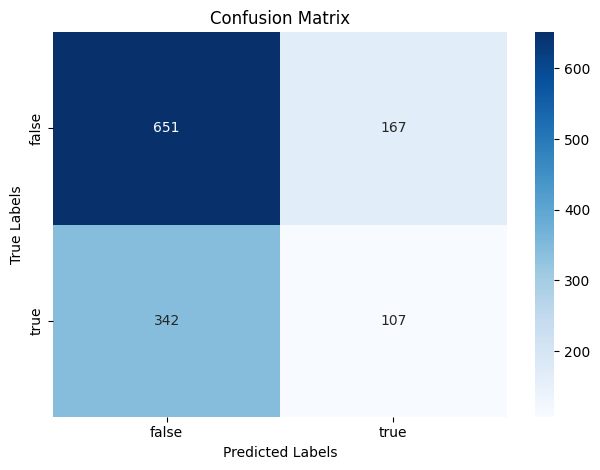

In [4]:
# Train final model with best hyperparameters
print("Best Hyperparameters:", best)
best_params = {
    'embedding_dim': int(best['embedding_dim']),
    'hidden_dim': int(best['hidden_dim']),
    'n_layers': int(best['n_layers']),
    'dropout': best['dropout'],
    'learning_rate': best['learning_rate']
}

final_model = BiLSTMModel(
    input_dim=train_vocab_size + 1,
    embedding_dim=best_params['embedding_dim'],
    hidden_dim=best_params['hidden_dim'],
    output_dim=train_label_counts.shape[0],
    n_layers=best_params['n_layers'],
    dropout=best_params['dropout']
)
final_model.to(device)

optimizer = optim.AdamW(final_model.parameters(), lr=best_params['learning_rate'])

# Example of using class weights:
class_weights = torch.tensor([2.0, 1.0], dtype=torch.float).to(device) # You might need to adjust these
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion.to(device)

# Train the final model on the combined training and validation sets
combined_X = torch.cat((X_train, X_val), dim=0)
combined_y = torch.cat((y_train, y_val), dim=0)
combined_dataset = TensorDataset(combined_X, combined_y)
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train_model(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_tps = 0
        total_samples = 0
        y_true = []
        y_pred = []

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Track total loss
            # Track total accuracy
            _, predicted_classes = torch.max(predictions, 1)
            epoch_tps += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_classes.cpu().numpy())

        y_true = torch.tensor(y_true, dtype=torch.long)
        y_pred = torch.tensor(y_pred, dtype=torch.long)

        results, f1_macro = evaluate(y_true, train_label_counts.shape[0], y_pred, y_pred, y_pred, label_encoder.classes_) # Pass dummy values for baseline and random

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f} | Accuracy: {epoch_tps/total_samples:.4f}")
        print(f"  Per-Class Precision: {results['Model']['Per-Class Precision']}")
        print(f"  Per-Class Recall: {results['Model']['Per-Class Recall']}")
        print(f"  Per-Class F1: {results['Model']['Per-Class F1']}")
        print(f"  Macro F1: {results['Model']['Macro F1']}")

train_model(final_model, combined_loader, optimizer, criterion, device, epochs=20)

"""## Evaluate Model"""

def evaluate_data(model, loader, num_classes, num_instances, label_ordering, orig_label_counts, device):
    model_pred, labels = get_predictions(loader, model, num_instances, pred_type='model', device=device)
    baseline_pred = get_predictions(
        loader, model, num_instances, pred_type='baseline',
        label_ordering=label_ordering, orig_label_counts=orig_label_counts
    )
    random_pred = get_predictions(loader, model, num_instances, pred_type='random', num_classes=num_classes)

    print()

    labels = labels.cpu()
    model_pred = model_pred.cpu()
    baseline_pred = baseline_pred.cpu()
    random_pred = random_pred.cpu()

    results, _ = evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering)
    pprint.pprint(results)

    conf_matrix = confusion_matrix(labels.cpu(), model_pred.cpu())
    class_labels = label_ordering

    def plot_confusion_matrix(conf_matrix, class_labels):
        sns.heatmap(
            conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.tight_layout()
        plt.show()

    print("\n")
    plot_confusion_matrix(conf_matrix, class_labels)

X_test, _, _, _, y_test = as_tensors("test", label_encoder, input_vector_size, token_to_idx)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

evaluate_data(final_model, test_loader, train_label_counts.shape[0], y_test.size(0), label_encoder.classes_, train_label_counts, device)

## IMPROVED HYPERPARAMETER STUFF BELOW


In [ ]:
import numpy as np
import pandas as pd
import random
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
import pprint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hyperopt imports
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

random.seed(184)

nltk.download('stopwords')
nltk.download('punkt')

peek = 20

def present_list_like(name, list_like, peek=peek):
    print(f"{name} peek:")
    print('  ' + '\n  '.join(str(v) for v in list_like[:peek]))

columns = [
    'id', 'label', 'claim', 'subject', 'speaker', 'speaker_job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]
present_list_like(f"Dataset columns({len(columns)} in total)", columns, len(columns))

def load_data(split):
    df = pd.read_csv(f"./data/{split}.tsv", sep='\t', names=columns)
    df = df.drop(index=[
        idx for idx in df.index if type(df["claim"][idx]) == type(None) or not len(df["claim"][idx])
    ])
    print("The training dataset:")
    df.info()
    print("\nData peek:")
    print(df.head(peek))
    print()
    return df

pad_tkn = "<PAD>"

def tokenize_text(input_text, known_vector_size=None, token_to_idx={}):
    def preprocess_text(text) -> str:
        # Letter-level cleaning
        text = text.lower()
        valid_asciis = {9, *range(32, 127)}
        text = ''.join(filter(lambda x: ord(x) in valid_asciis, text))

        # Word/sequence-level cleaning
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'http\S+', '', text)
        stop_words = set(stopwords.words('english'))
        text = ' '.join(word for word in text.split() if word not in stop_words)
        return text

    # Preprocess the text
    for i in range(len(input_text)):
        input_text[i] = preprocess_text(input_text[i])

    # Tokenize
    final_tokens = input_tokens = [nltk.word_tokenize(text) for text in input_text]
    total_tokens = sum(len(tkns) for tkns in final_tokens)

    # Make all token sets the same length
    forced_tkn_set_size = (
        known_vector_size if known_vector_size
        else int(np.percentile([len(tkns) for tkns in final_tokens], 80))
    )
    final_tokens = [
        tkns[:forced_tkn_set_size] + [pad_tkn] * (forced_tkn_set_size - len(tkns))
        for tkns in final_tokens
    ]

    # Present results
    present_list_like(
        f"Tokenized sentences({len(final_tokens)} sentences, {total_tokens} total tokens)",
        final_tokens
    )

    # Index the tokens
    # Map each token to its frequency in the dataset
    if not len(token_to_idx):
        flat_tokens = [word for token_set in final_tokens for word in token_set]
        frequencies = Counter(flat_tokens)
        token_to_idx = {}
        for idx, (word, _) in enumerate(frequencies.most_common()):
            if idx >= 10000:
                break
            token_to_idx[word] = idx + 1
        if pad_tkn not in token_to_idx:
            token_to_idx[pad_tkn] = len(token_to_idx) + 1
    vocab_size = len(token_to_idx)
    print()
    print(vocab_size, "unique tokens")
    present_list_like("Unique tokens", list(token_to_idx.keys()))

    # Index the tokens
    freq_indexed = [
        [(token_to_idx[token] if token in token_to_idx else 0) for token in token_set]
        for token_set in final_tokens
    ]

    # Present results
    present_list_like(
        f"\nFinal Index Sets(Set_Size = {forced_tkn_set_size}, {len(freq_indexed)} index sets)",
        freq_indexed
    )

    return freq_indexed, token_to_idx

def get_freq_indexed_and_labels(split, known_vector_size=None, token_to_idx={}):
    df = load_data(split)
    input_text = df["claim"].to_numpy()
    # Augment input text with the other columns
    other_cols = {
        "context",
        "subject",
        "speaker",
        "speaker_job_title",
        "state_info",
        "party_affiliation",
    }
    for i in range(len(input_text)):
        extra_data = [f"{col}: {df[col].values[i]}" for col in other_cols if df[col].values[i]]
        input_text[i] += " | \n" * (len(extra_data) > 0) + " | \n".join(extra_data)
    input_labels = df["label"].to_numpy()
    # Fuse some labels
    input_labels = np.array([
        "false" if x in ("false", "half-true", "barely-true", "pants-fire")
        else "true" if x in ("true", "mostly-true")
        else x
        for x in input_labels
    ])
    freq_indexed, token_to_idx = tokenize_text(input_text, known_vector_size, token_to_idx)

    return freq_indexed, token_to_idx, input_labels

def as_tensors(split, label_encoder=None, known_vector_size=None, token_to_idx={}):
    freq_indexed, token_to_idx, input_labels = get_freq_indexed_and_labels(split, known_vector_size, token_to_idx)
    X = torch.tensor(freq_indexed, dtype=torch.long)
    label_encoder_existed = (type(label_encoder) != type(None))
    label_encoder = (LabelEncoder() if not label_encoder_existed else label_encoder)
    y = (
        label_encoder.fit_transform(input_labels) if not label_encoder_existed
        else label_encoder.transform(input_labels)
    )
    y = torch.tensor(y, dtype=torch.long)
    print(f"{split.upper()} SPLIT:", X.size(0), "overall samples:", X.shape)

    return X, token_to_idx, label_encoder, input_labels, y

BATCH_SIZE = 32

X_train, token_to_idx, label_encoder, train_input_labels, y_train = as_tensors("train")
X_val, _, _, _, y_val = as_tensors("valid", label_encoder=label_encoder, known_vector_size=X_train.shape[1], token_to_idx=token_to_idx)

label_to_idx = {l: i for i, l in enumerate(label_encoder.classes_)}
train_vocab_size = len(token_to_idx)
input_vector_size = X_train.shape[1]

# Use validation set for evaluation during hyperparameter tuning
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_label_counts = pd.DataFrame({"label": train_input_labels})["label"].value_counts(normalize=True)
print(train_label_counts.shape[0], "labels\n")
print(train_label_counts)

# Balance if necessary
print(f"TRAIN SPLIT(pre-balancing):", X_train.size(0), "overall samples:", X_train.shape)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
print()
print(f"TRAIN SPLIT(post-balancing):", X_train.size(0), "overall samples:", X_train.shape)
print(pd.DataFrame({"label": [label_encoder.classes_[y] for y in y_train]})["label"].value_counts())

# Define the model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=token_to_idx[pad_tkn])
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(hidden)

# Evaluation functions (modified to return Macro F1 for optimization)
def per_class_metrics(labels, predictions, num_classes, label_ordering):
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_per_class = precision_score(
        labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0
    )
    recall_per_class = recall_score(
        labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0
    )
    f1_per_class = f1_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)

    results = []
    for metrics in [precision_per_class, recall_per_class, f1_per_class]:
        results.append({label_ordering[i]: metrics[i] for i in range(len(metrics))})
    return tuple(results)

def macro_metrics(labels, predictions):
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)

    return precision_macro, recall_macro, f1_macro

def micro_metrics(labels, predictions):
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    precision_micro = precision_score(labels, predictions, average='micro', zero_division=0)
    recall_micro = recall_score(labels, predictions, average='micro', zero_division=0)
    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)

    return precision_micro, recall_micro, f1_micro

def evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering):
    results = {}

    for pred_type, predictions in [('Model', model_pred), ('Baseline', baseline_pred), ('Random', random_pred)]:
        curr_results = results[pred_type] = {}

        # Calculate metrics
        accuracy = (predictions == labels).sum().item() / labels.size(0)
        precision_per_class, recall_per_class, f1_per_class = per_class_metrics(
            labels, predictions, num_classes, label_ordering
        )
        precision_macro, recall_macro, f1_macro = macro_metrics(labels, predictions)
        precision_micro, recall_micro, f1_micro = micro_metrics(labels, predictions)

        # Save all metrics
        curr_results["Accuracy"] = accuracy
        curr_results["Per-Class Precision"] = precision_per_class
        curr_results["Per-Class Recall"] = recall_per_class
        curr_results["Per-Class F1"] = f1_per_class
        curr_results["Macro Precision"] = precision_macro
        curr_results["Macro Recall"] = recall_macro
        curr_results["Macro F1"] = f1_macro
        curr_results["Micro Precision"] = precision_micro
        curr_results["Micro Recall"] = recall_micro
        curr_results["Micro F1"] = f1_micro

    return results, f1_macro

# Get predictions
import typing as tp

def get_predictions(
    test_loader, model, num_samples,
    pred_type: tp.Literal['model', 'baseline', 'random'] = 'model',
    device=None,
    label_ordering=None, orig_label_counts=None,
    num_classes=None
):
    predictions = []
    y_eval = []

    if pred_type == 'model':
        model.eval()
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                y_eval.extend(batch_y)

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                batch_size = batch_X.size(0)

                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu())
        y_eval = torch.tensor(y_eval, dtype=torch.long)
    elif pred_type == 'baseline':
        orig_label_counts = orig_label_counts.sort_index(key=lambda idx: orig_label_counts[idx], inplace=False, ascending=False)
        majority_class = list(label_ordering).index(orig_label_counts.index[0])
        predictions += [majority_class for _ in range(num_samples)]
    else:
        predictions += [random.randint(0, num_classes - 1) for _ in range(num_samples)]

    predictions = torch.tensor(predictions, dtype=torch.long)
    if pred_type == 'model':
        return predictions, y_eval
    return predictions

# Hyperparameter space
space = {
    'embedding_dim': scope.int(hp.quniform('embedding_dim', 50, 500, 50)),
    'hidden_dim': scope.int(hp.quniform('hidden_dim', 32, 256, 32)),
    'n_layers': scope.int(hp.quniform('n_layers', 1, 3, 1)),
    'dropout': hp.uniform('dropout', 0.1, 0.7),
    'learning_rate': hp.loguniform('learning_rate', -6, -2),  # 0.002 - 0.01
}

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    best_val_loss = float('inf')
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        # --- Training phase ---
        model.train() # Ensure model is in training mode
        train_epoch_loss = 0
        train_epoch_tps = 0
        train_total_samples = 0
        y_true_train = []
        y_pred_train = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            _, predicted_classes = torch.max(predictions, 1)
            train_epoch_tps += (predicted_classes == labels).sum().item()
            train_total_samples += labels.size(0)

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted_classes.cpu().numpy())

        y_true_train = torch.tensor(y_true_train, dtype=torch.long)
        y_pred_train = torch.tensor(y_pred_train, dtype=torch.long)

        train_results, train_f1_macro = evaluate(y_true_train, train_label_counts.shape[0], y_pred_train, y_pred_train, y_pred_train, label_encoder.classes_)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_epoch_loss/len(train_loader):.4f} | Train Accuracy: {train_epoch_tps/train_total_samples:.4f}")
        print(f"  Train Per-Class Precision: {train_results['Model']['Per-Class Precision']}")
        print(f"  Train Per-Class Recall: {train_results['Model']['Per-Class Recall']}")
        print(f"  Train Per-Class F1: {train_results['Model']['Per-Class F1']}")
        print(f"  Train Macro F1: {train_results['Model']['Macro F1']}")

        # --- Validation phase ---
        val_loss = 0
        model.eval() # Switch to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = model(inputs)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"  Validation Loss: {val_loss:.4f}")

        # Save the model if the validation loss is better than the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  Best model saved to {best_model_path} (val_loss={best_val_loss:.4f})")

    # Load the best model
    print(f"Loading best model from {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))

# Objective function for Hyperopt
def objective(params):
    print("Training with params:")
    print(params)

    # Create model
    model = BiLSTMModel(
        input_dim=train_vocab_size + 1,
        embedding_dim=params['embedding_dim'],
        hidden_dim=params['hidden_dim'],
        output_dim=train_label_counts.shape[0],
        n_layers=params['n_layers'],
        dropout=params['dropout']
    )
    model.to(device)

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'])

    # Loss function (consider class weights if imbalanced)
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    # Train
    train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10)

    # Evaluate on validation set
    model_pred, labels = get_predictions(val_loader, model, y_val.size(0), pred_type='model', device=device)
    baseline_pred = get_predictions(
        val_loader, model, y_val.size(0), pred_type='baseline',
        label_ordering=label_encoder.classes_, orig_label_counts=train_label_counts
    )
    random_pred = get_predictions(val_loader, model, y_val.size(0), pred_type='random', num_classes=train_label_counts.shape[0])

    _, f1_macro = evaluate(labels, train_label_counts.shape[0], model_pred, baseline_pred, random_pred, label_encoder.classes_)

    # Hyperopt minimizes the objective, so return negative F1 Macro
    return {'loss': -f1_macro, 'status': STATUS_OK}

# Move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    t4_available = any("t4" in torch.cuda.get_device_name(i).lower() for i in range(num_gpus))
    print(f"Is a T4 GPU available? {t4_available}")
    device = torch.device('cuda:0')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU.")
    device = torch.device('cpu')

# Run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best hyperparameters found:")
print(best)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset columns(14 in total) peek:
  id
  label
  claim
  subject
  speaker
  speaker_job_title
  state_info
  party_affiliation
  barely_true_counts
  false_counts
  half_true_counts
  mostly_true_counts
  pants_on_fire_counts
  context
The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   claim                 10240 non-null  object 
 3   subject               10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   speaker_job_title     7342 non-null   object 
 6   state_info            8030 non-null   object 
 7   party_affiliation     10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_coun

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



TRAIN SPLIT(post-balancing): 13204 overall samples: torch.Size([13204, 49])
label
false    6602
true     6602
Name: count, dtype: int64
Number of available GPUs: 1
GPU 0: Tesla T4
Is a T4 GPU available? True
Using GPU: Tesla T4
Training with params:
{'dropout': 0.17359782539133228, 'embedding_dim': 250, 'hidden_dim': 96, 'learning_rate': 0.02103633411648602, 'n_layers': 3}
Epoch 1/10 | Train Loss: 0.6624 | Train Accuracy: 0.6362
  Train Per-Class Precision: {'false': 0.6474023977866584, 'true': 0.4095634095634096}
  Train Per-Class Recall: {'false': 0.9569827325053014, 'true': 0.05415063221550302}
  Train Per-Class F1: {'false': 0.7723244300470632, 'true': 0.09565428502063608}
  Train Macro F1: 0.43398935753384965
  Validation Loss: 0.6303
  Best model saved to best_model.pth (val_loss=0.6303)
Epoch 2/10 | Train Loss: 0.6439 | Train Accuracy: 0.6418
  Train Per-Class Precision: {'false': 0.6590416305290546, 'true': 0.48523622047244097}
  Train Per-Class Recall: {'false': 0.92078158133

<ipython-input-13-0b51d53853bb>:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Epoch 1/10 | Train Loss: 0.6480 | Train Accuracy: 0.6439
  Train Per-Class Precision: {'false': 0.6486024532475367, 'true': 0.48639455782312924}
  Train Per-Class Recall: {'false': 0.9771281429869736, 'true': 0.03930731170973062}
  Train Per-Class F1: {'false': 0.7796712593666908, 'true': 0.07273652085452696}
  Train Macro F1: 0.4262038901106089
  Validation Loss: 0.6137
  Best model saved to best_model.pth (val_loss=0.6137)
Epoch 2/10 | Train Loss: 0.6064 | Train Accuracy: 0.6725
  Train Per-Class Precision: {'false': 0.690924053609217, 'true': 0.5818915801614764}
  Train Per-Class Recall: {'false': 0.8901847924871251, 'true': 0.27735019241341397}
  Train Per-Class F1: {'false': 0.7779984114376489, 'true': 0.37565152643335814}
  Train Macro F1: 0.5768249689355035
  Validation Loss: 0.6110
  Best model saved to best_model.pth (val_loss=0.6110)
Epoch 3/10 | Train Loss: 0.5263 | Train Accuracy: 0.7394
  Train Per-Class Precision: {'false': 0.7722552955835525, 'true': 0.6605899900563473}


<ipython-input-13-0b51d53853bb>:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



{'dropout': 0.23222950781790103, 'embedding_dim': 300, 'hidden_dim': 64, 'learning_rate': 0.011813170424378244, 'n_layers': 2}
Epoch 1/10 | Train Loss: 0.6496 | Train Accuracy: 0.6417
  Train Per-Class Precision: {'false': 0.6501484590969592, 'true': 0.46723044397463004}
  Train Per-Class Recall: {'false': 0.9618297485610421, 'true': 0.06074766355140187}
  Train Per-Class F1: {'false': 0.7758568024925163, 'true': 0.10751641936268548}
  Train Macro F1: 0.4416866109276009
  Validation Loss: 0.6124
  Best model saved to best_model.pth (val_loss=0.6124)
Epoch 2/10 | Train Loss: 0.5949 | Train Accuracy: 0.6819
  Train Per-Class Precision: {'false': 0.7087754337785545, 'true': 0.585464333781965}
  Train Per-Class Recall: {'false': 0.8600424113904878, 'true': 0.35871357888949973}
  Train Per-Class F1: {'false': 0.777116266338192, 'true': 0.44486108743821373}
  Train Macro F1: 0.6109886768882029
  Validation Loss: 0.6367
Epoch 3/10 | Train Loss: 0.5150 | Train Accuracy: 0.7484
  Train Per-Clas

<ipython-input-13-0b51d53853bb>:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Epoch 1/10 | Train Loss: 0.6802 | Train Accuracy: 0.6169
  Train Per-Class Precision: {'false': 0.6496480840129595, 'true': 0.3894491854150504}
  Train Per-Class Recall: {'false': 0.8807936988791275, 'true': 0.13798790544255085}
  Train Per-Class F1: {'false': 0.7477657043657172, 'true': 0.2037751167038766}
  Train Macro F1: 0.4757704105347969
  Validation Loss: 0.6383
  Best model saved to best_model.pth (val_loss=0.6383)
Epoch 2/10 | Train Loss: 0.6729 | Train Accuracy: 0.6195
  Train Per-Class Precision: {'false': 0.6560913705583756, 'true': 0.4179389312977099}
  Train Per-Class Recall: {'false': 0.8614056346561648, 'true': 0.1805937328202309}
  Train Per-Class F1: {'false': 0.7448592010478061, 'true': 0.25220729366602684}
  Train Macro F1: 0.4985332473569165
  Validation Loss: 0.6839
Epoch 3/10 | Train Loss: 0.6839 | Train Accuracy: 0.6130
  Train Per-Class Precision: {'false': 0.6541291905151267, 'true': 0.4032162001191185}
  Train Per-Class Recall: {'false': 0.8482278097546199, '

<ipython-input-13-0b51d53853bb>:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Epoch 1/10 | Train Loss: 0.6924 | Train Accuracy: 0.6083
  Train Per-Class Precision: {'false': 0.6474001592900216, 'true': 0.3714679531357684}
  Train Per-Class Recall: {'false': 0.8618600424113905, 'true': 0.14815832875206159}
  Train Per-Class F1: {'false': 0.7393931518419856, 'true': 0.21182943603851445}
  Train Macro F1: 0.47561129394025004
  Validation Loss: 0.6390
  Best model saved to best_model.pth (val_loss=0.6390)
Epoch 2/10 | Train Loss: 0.6739 | Train Accuracy: 0.6234
  Train Per-Class Precision: {'false': 0.656129178985672, 'true': 0.42461964038727523}
  Train Per-Class Recall: {'false': 0.8739775825507422, 'true': 0.16877405167674547}
  Train Per-Class F1: {'false': 0.7495453364510263, 'true': 0.24154209284028325}
  Train Macro F1: 0.4955437146456548
  Validation Loss: 0.6385
  Best model saved to best_model.pth (val_loss=0.6385)
Epoch 3/10 | Train Loss: 0.6656 | Train Accuracy: 0.6292
  Train Per-Class Precision: {'false': 0.6589235127478753, 'true': 0.44381625441696115

<ipython-input-13-0b51d53853bb>:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Training with params:
{'dropout': 0.33936392123706527, 'embedding_dim': 250, 'hidden_dim': 96, 'learning_rate': 0.04472961886479249, 'n_layers': 2}
Epoch 1/10 | Train Loss: 0.7028 | Train Accuracy: 0.6139
  Train Per-Class Precision: {'false': 0.6522889348976305, 'true': 0.3978007761966365}
  Train Per-Class Recall: {'false': 0.8589821266282944, 'true': 0.16904892798240792}
  Train Per-Class F1: {'false': 0.7415010460251046, 'true': 0.23726851851851852}
  Train Macro F1: 0.48938478227181154
  Validation Loss: 0.6592
  Best model saved to best_model.pth (val_loss=0.6592)
Epoch 2/10 | Train Loss: 0.7412 | Train Accuracy: 0.5878
  Train Per-Class Precision: {'false': 0.6487939007624047, 'true': 0.3698079499776686}
  Train Per-Class Recall: {'false': 0.7862768857921841, 'true': 0.22759758108851016}
  Train Per-Class F1: {'false': 0.710949804834623, 'true': 0.28177641653905056}
  Train Macro F1: 0.4963631106868368
  Validation Loss: 0.7960
Epoch 3/10 | Train Loss: 0.8954 | Train Accuracy: 0

<ipython-input-13-0b51d53853bb>:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Epoch 1/10 | Train Loss: 0.6517 | Train Accuracy: 0.6362
  Train Per-Class Precision: {'false': 0.65613806577662, 'true': 0.45764362220058424}
  Train Per-Class Recall: {'false': 0.9156316267797637, 'true': 0.12919186366135238}
  Train Per-Class F1: {'false': 0.7644641163452418, 'true': 0.2015005359056806}
  Train Macro F1: 0.4829823261254612
  Validation Loss: 0.6210
  Best model saved to best_model.pth (val_loss=0.6210)
 12%|█▏        | 6/50 [02:46<19:20, 26.37s/trial, best loss: -0.49904337452450087]

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# ... (rest of your imports and functions)

# Train final model with best hyperparameters
print("Best Hyperparameters:", best)
best_params = {
    'embedding_dim': int(best['embedding_dim']),
    'hidden_dim': int(best['hidden_dim']),
    'n_layers': int(best['n_layers']),
    'dropout': best['dropout'],
    'learning_rate': best['learning_rate']
}

final_model = BiLSTMModel(
    input_dim=train_vocab_size + 1,
    embedding_dim=best_params['embedding_dim'],
    hidden_dim=best_params['hidden_dim'],
    output_dim=train_label_counts.shape[0],
    n_layers=best_params['n_layers'],
    dropout=best_params['dropout']
)
final_model.to(device)

optimizer = optim.AdamW(final_model.parameters(), lr=best_params['learning_rate'])

# Example of using class weights:
class_weights = torch.tensor([2.0, 1.0], dtype=torch.float).to(device) # You might need to adjust these
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion.to(device)

# --- Validation data setup ---
X_val, _, _, _, y_val = as_tensors("valid", label_encoder=label_encoder, known_vector_size=X_train.shape[1], token_to_idx=token_to_idx)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Train the final model on the combined training and validation sets
combined_X = torch.cat((X_train, X_val), dim=0)
combined_y = torch.cat((y_train, y_val), dim=0)
combined_dataset = TensorDataset(combined_X, combined_y)
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    # Move model to device
    model.to(device)

    best_val_loss = float('inf')
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        # --- Training phase ---
        model.train()  # Put model in training mode
        train_epoch_loss = 0
        train_epoch_tps = 0
        train_total_samples = 0
        y_true_train = []
        y_pred_train = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            _, predicted_classes = torch.max(predictions, 1)
            train_epoch_tps += (predicted_classes == labels).sum().item()
            train_total_samples += labels.size(0)

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted_classes.cpu().numpy())

        y_true_train = torch.tensor(y_true_train, dtype=torch.long)
        y_pred_train = torch.tensor(y_pred_train, dtype=torch.long)

        train_results, train_f1_macro = evaluate(y_true_train, train_label_counts.shape[0], y_pred_train, y_pred_train, y_pred_train, label_encoder.classes_)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_epoch_loss/len(train_loader):.4f} | Train Accuracy: {train_epoch_tps/train_total_samples:.4f}")
        print(f"  Train Per-Class Precision: {train_results['Model']['Per-Class Precision']}")
        print(f"  Train Per-Class Recall: {train_results['Model']['Per-Class Recall']}")
        print(f"  Train Per-Class F1: {train_results['Model']['Per-Class F1']}")
        print(f"  Train Macro F1: {train_results['Model']['Macro F1']}")

        # --- Validation phase ---
        val_loss = 0
        model.eval()  # Put model in evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = model(inputs)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"  Validation Loss: {val_loss:.4f}")

        # Save the model if the validation loss is better than the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  Best model saved to {best_model_path} (val_loss={best_val_loss:.4f})")

    # Load the best model
    print(f"Loading best model from {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    return model

# Call train_model and assign the returned model back to final_model
final_model = train_model(final_model, combined_loader, val_loader, optimizer, criterion, device, epochs=20)

"""## Evaluate Model"""

def evaluate_data(model, loader, num_classes, num_instances, label_ordering, orig_label_counts, device):
    model.eval()
    model_pred, labels = get_predictions(loader, model, num_instances, pred_type='model', device=device)
    baseline_pred = get_predictions(
        loader, model, num_instances, pred_type='baseline',
        label_ordering=label_ordering, orig_label_counts=orig_label_counts
    )
    random_pred = get_predictions(loader, model, num_instances, pred_type='random', num_classes=num_classes)

    print()

    labels = labels.cpu()
    model_pred = model_pred.cpu()
    baseline_pred = baseline_pred.cpu()
    random_pred = random_pred.cpu()

    results, _ = evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering)
    pprint.pprint(results)

    conf_matrix = confusion_matrix(labels.cpu(), model_pred.cpu())
    class_labels = label_ordering

    def plot_confusion_matrix(conf_matrix, class_labels):
        sns.heatmap(
            conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.tight_layout()
        plt.show()

    print("\n")
    plot_confusion_matrix(conf_matrix, class_labels)

X_test, _, _, _, y_test = as_tensors("test", label_encoder, input_vector_size, token_to_idx)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

evaluate_data(final_model, test_loader, train_label_counts.shape[0], y_test.size(0), label_encoder.classes_, train_label_counts, device)

Best Hyperparameters: {'dropout': 0.3637721950380055, 'embedding_dim': 150.0, 'hidden_dim': 256.0, 'learning_rate': 0.013031848705016969, 'n_layers': 1.0}
The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1284 non-null   object
 1   label                 1284 non-null   object
 2   claim                 1284 non-null   object
 3   subject               1284 non-null   object
 4   speaker               1284 non-null   object
 5   speaker_job_title     939 non-null    object
 6   state_info            1005 non-null   object
 7   party_affiliation     1284 non-null   object
 8   barely_true_counts    1284 non-null   int64 
 9   false_counts          1284 non-null   int64 
 10  half_true_counts      1284 non-null   int64 
 11  mostly_true_counts    1284 non-null   int64 
 12  pants_on_fi

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3637721950380055 and num_layers=1
  warnings.warn(


Tokenized sentences(1284 sentences, 55513 total tokens) peek:
  ['less', 'americans', 'working', '70s', '.', '|', 'state_info', ':', 'missouri', '|', 'party_affiliation', ':', 'republican', '|', 'speaker', ':', 'vicky-hartzler', '|', 'subject', ':', 'economy', ',', 'jobs', '|', 'context', ':', 'interview', 'abc17', 'news', '|', 'speaker_job_title', ':', 'u.s.', 'representative', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
  ['obama', 'sworn', 'office', ',', 'use', 'holy', 'bible', ',', 'instead', 'kuran', '(', 'their', 'equivalency', 'bible', ',', 'different', 'beliefs', ')', '.', '|', 'state_info', ':', 'nan', '|', 'party_affiliation', ':', 'none', '|', 'speaker', ':', 'chain-email', '|', 'subject', ':', 'obama-birth-certificate', ',', 'religion', '|', 'context', ':', 'nan', '|', 'speaker_job_title', ':', 'nan', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
  ['says', 'organizations', 'parading', 'social'

RuntimeError: cudnn RNN backward can only be called in training mode